In [1]:
import numpy as np
from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt
from IPython.display import Image

## Gravitational Orbits class and utility functions

In [2]:
class Gravitational_orbit():
    """
     Gravitational_orbit class implements the parameters and Lagrange's equations for 
     two bodies orbiting under gravity.
     
    Parameters
    ----------
   
    G : float
        gravitational acceleration 
    Mn : float
        mass of pendulum, n is the pendulum bob number 

    Methods
    -------
    dy_dt(t, y)
        Returns the right side of the differential equation in vector y, 
        given time t and the corresponding value of y.
    """
    
    def __init__(self, M1 = 1., M2 = 1., G = 1.):
        
        self.M1 = M1
        self.M2 = M2
        self.G = G
        
    def dz_dt(self, t, z):
        """
        This function returns the right-hand side of the diffeq: 
        [dz/dt d^2z/dt^2]
        
        Parameters
        ----------
        y : float
            A 8-component vector with 
            z[0] = x1(t) and z[1] = dx1/dt
            z[2] = y1(t) and z[3] = dy1/dt
            z[4] = x2(t) and z[5] = dx2/dt
            z[6] = y2(t) and z[7] = dy2/dt
        t : float
            time 
            
        Returns
        -------
        
        """
        r_12 = np.sqrt((z[0]-z[4])**2 + (z[2]-z[6])**2)
                  
        return [z[1], self.G*self.M2*(z[4]-z[0])/r_12**3,\
               z[3], self.G*self.M2*(z[6]-z[2])/r_12**3,\
               z[5], -self.G*self.M1*(z[4]-z[0])/r_12**3,\
               z[7], -self.G*self.M1*(z[6]-z[2])/r_12**3,\
               ]
    
   
    def solve_ode(self, t_pts, z_0,
                  abserr=1.0e-8, relerr=1.0e-8):
        """
        Solve the ODE given the array of time points and initial conditions.
        Specify smaller abserr and relerr to get more precision.
        """
       
        solution = solve_ivp(self.dz_dt, (t_pts[0], t_pts[-1]), z_0,
                             t_eval = t_pts, method='RK23',
                             atol=abserr, rtol=relerr)
        x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot = solution.y
        
        return x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot
    
    def solve_ode_Leapfrog(self, t_pts, z_0):
        """
        Solve the ODE given initial conditions with the Leapfrog method.
        """
        delta_t = t_pts[1] - t_pts[0]
        x1_0, x1_dot_0, y1_0, y1_dot_0, x2_0, x2_dot_0, y2_0, y2_dot_0 = z_0
        
        
        # initialize the arrays 
        num_t_pts = len(t_pts)
        x1 = np.zeros(num_t_pts)
        x1_dot = np.zeros(num_t_pts)
        x1_dot_half = np.zeros(num_t_pts)
        
        y1 = np.zeros(num_t_pts)
        y1_dot = np.zeros(num_t_pts)
        y1_dot_half = np.zeros(num_t_pts)
        
        x2 = np.zeros(num_t_pts)
        x2_dot = np.zeros(num_t_pts)
        x2_dot_half = np.zeros(num_t_pts)
        
        y2 = np.zeros(num_t_pts)
        y2_dot = np.zeros(num_t_pts)
        y2_dot_half = np.zeros(num_t_pts)
        
        
        # initial conditions
        x1[0] = x1_0
        x1_dot[0] = x1_dot_0
        
        y1[0] = y1_0
        y1_dot[0] = y1_dot_0
        
        x2[0] = x2_0
        x2_dot[0] = x2_dot_0
        
        y2[0] = y2_0
        y2_dot[0] = y2_dot_0
        
        # step through the differential equation
        for i in np.arange(num_t_pts - 1):
            t = t_pts[i]
            z = [x1[i], x1_dot[i], y1[i], y1_dot[i], x2[i], x2_dot[i],
                 y2[i], y2_dot[i]]
            out=self.dz_dt(t,z)
            
            x1_dot_half[i] = x1_dot[i] + out[1] * delta_t/2.
            x1[i+1] = x1[i] + x1_dot_half[i] * delta_t
            
            y1_dot_half[i] = y1_dot[i] + out[3] * delta_t/2.
            y1[i+1] = y1[i] + y1_dot_half[i] * delta_t
            
            x2_dot_half[i] = x2_dot[i] + out[5] * delta_t/2.
            x2[i+1] = x2[i] + x2_dot_half[i] * delta_t
            
            y2_dot_half[i] = y2_dot[i] + out[7] * delta_t/2.
            y2[i+1] = x1[i] + y2_dot_half[i] * delta_t
            
            z =[x1[i+1], x1_dot[i], y1[i+1], y1_dot[i], 
                x2[i+1], x2_dot[i], y2[i+1], y2_dot[i]]
            out = self.dz_dt(t,z)
            
            x1_dot[i+1] = x1_dot_half[i] + out[1] * delta_t/2.
            y1_dot[i+1] = y1_dot_half[i] + out[3] * delta_t/2.
            x2_dot[i+1] = x2_dot_half[i] + out[5] * delta_t/2.
            y2_dot[i+1] = y2_dot_half[i] + out[7] * delta_t/2.
            
        return x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot
   

In [3]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

In [4]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    """Given an array (e.g., of times) and desired starting and stop values,
        return the array indices that are closest to those values.
    """
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

In [5]:
orbit_labels = (r'$x$', r'$y$')

# Plotting time 
t_start = 0.
t_end = 10.
delta_t = 0.01

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

G =1. 
M1= 1.
M2 =5.

o1=Gravitational_orbit(M1,M2,G)

#initial conditions:
x1_0, x1_dot_0 = 1., -1.
y1_0, y1_dot_0 = 1., 1.
x2_0, x2_dot_0 = -(M1/M2)*x1_0, -(M1/M2)*x1_dot_0
y2_0, y2_dot_0 = -(M1/M2)*y1_0, -(M1/M2)*y1_dot_0

z_0 = [x1_0, x1_dot_0, y1_0, y1_dot_0, x2_0, x2_dot_0, y2_0, y2_dot_0]
x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot=o1.solve_ode(t_pts,z_0)


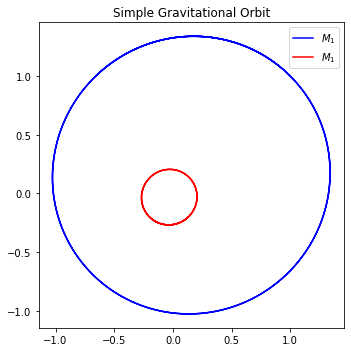

In [6]:
#Plot!!
fig=plt.figure(figsize=(5,5))

ax = fig.add_subplot(1,1,1)

start, stop = start_stop_indices(t_pts, t_start, t_end)    
ax.plot(x1,y1,color='blue',label=r'$M_1$')
ax.plot(x2,y2,color='red',label=r'$M_1$')

ax.set_title('Simple Gravitational Orbit')
ax.legend()
ax.set_aspect(1)

fig.tight_layout()
fig.savefig('simple_orbits.png', bbox_inches='tight')


## For one mass much larger than the other: 

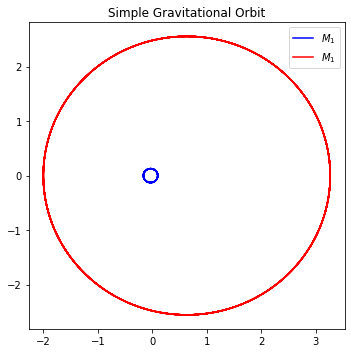

In [7]:
orbit_labels = (r'$x$', r'$y$')

# Plotting time 
t_start = 0.
t_end = 10.
delta_t = 0.00001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

G =20. 
M1= 20.
M2 =1.

o1=Gravitational_orbit(M1,M2,G)

#initial conditions:
x1_0, x1_dot_0 = 0.1, 0.
y1_0, y1_dot_0 = 0., 0.75
x2_0, x2_dot_0 = -(M1/M2)*x1_0, -(M1/M2)*x1_dot_0
y2_0, y2_dot_0 = -(M1/M2)*y1_0, -(M1/M2)*y1_dot_0

z_0 = [x1_0, x1_dot_0, y1_0, y1_dot_0, x2_0, x2_dot_0, y2_0, y2_dot_0]
x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot=o1.solve_ode(t_pts,z_0)

#Plot!!
fig=plt.figure(figsize=(5,5))

ax = fig.add_subplot(1,1,1)

start, stop = start_stop_indices(t_pts, t_start, t_end)    
ax.plot(x1,y1,color='blue',label=r'$M_1$')
ax.plot(x2,y2,color='red',label=r'$M_1$')

ax.set_title('Simple Gravitational Orbit')
ax.legend()
ax.set_aspect(1)

fig.tight_layout()
fig.savefig('simple_orbits.png', bbox_inches='tight')



This reduces to the orbits considered in class if you are in the rest frame of the heavier body

In [8]:
# Plotting time 
t_start = 0.
t_end = 100.
delta_t = 0.01

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

G =10.
M1= 1.
M2 =1.

o1=Gravitational_orbit(M1,M2,G)

#initial conditions:
x1_0, x1_dot_0 = 1., 0.
y1_0, y1_dot_0 = 0., 1.
x2_0, x2_dot_0 = -(M1/M2)*x1_0, -(M1/M2)*x1_dot_0
y2_0, y2_dot_0 = -(M1/M2)*y1_0, -(M1/M2)*y1_dot_0

z_0 = [x1_0, x1_dot_0, y1_0, y1_dot_0, x2_0, x2_dot_0, y2_0, y2_dot_0]
x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot=o1.solve_ode(t_pts,z_0)


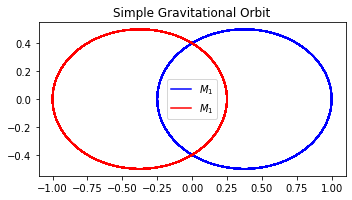

In [9]:
#Plot!!
fig=plt.figure(figsize=(5,5))

ax = fig.add_subplot(1,1,1)

start, stop = start_stop_indices(t_pts, t_start, t_end)    
ax.plot(x1,y1,color='blue',label=r'$M_1$')
ax.plot(x2,y2,color='red',label=r'$M_1$')

ax.set_title('Simple Gravitational Orbit')
ax.legend()
ax.set_aspect(1)

fig.tight_layout()
fig.savefig('simple_orbits.png', bbox_inches='tight')


In [10]:
from matplotlib import animation, rc
from IPython.display import HTML

In [11]:
%%capture
x_min = -1.2
x_max = -x_min
y_min = -1.2
y_max = -y_min

fig_anim = plt.figure(figsize=(5,3), num='Orbit')
ax_anim = fig_anim.add_subplot(1,1,1)
ax_anim.set_xlim(x_min, x_max)
ax_anim.set_ylim(y_min, y_max)

# By assigning the first return from plot to line_anim, we can later change
#  the values in the line.
# x0, y0 = 0.,0.
# pt0_anim, = ax_anim.plot(x0, y0, 
#                          'o', markersize=6,
#                          color='black')
# x1, y1 = xy_coords(x0, y0, theta1[0],p1.L1)
# pt1_anim, = ax_anim.plot(x1,y1,
#                         'o', markersize=12,
#                         color = 'blue')
ln1_anim,=ax_anim.plot(x1,y1,color='blue',lw=1)
ln2_anim,=ax_anim.plot(x2,y2, color='red',lw=1)

pt1_anim, = ax_anim.plot(x1[0],y1[0],
                        'o', markersize=12,
                        color = 'blue')
pt2_anim, = ax_anim.plot(x2[0],y2[0],
                        'o', markersize=12,
                        color = 'red')

ax_anim.set_aspect(1)
ax_anim.axis('off')
fig_anim.tight_layout()

In [12]:
def animate_pendulum(i):
    i_skip = 1 *i 
    
    
    pt1_anim.set_data(x1[i_skip],y1[i_skip])
    pt2_anim.set_data(x2[i_skip],y2[i_skip])
    
    
    return(pt1_anim, pt2_anim)
    

In [13]:
frame_interval = 20.  # time between frames
frame_number = 1001    # number of frames to include (index of t_pts)
anim = animation.FuncAnimation(fig_anim, 
                               animate_pendulum, 
                               init_func=None,
                               frames=frame_number, 
                               interval=frame_interval, 
                               blit=True,
                               repeat=False)

In [14]:
plt.tight_layout()
HTML(anim.to_jshtml())

<Figure size 432x288 with 0 Axes>

## Leapfrog method:

In [15]:
# Plotting time 
t_start = 0.
t_end = 100.
delta_t = 0.01

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

G =10.
M1= 1.
M2 =1.

o1=Gravitational_orbit(M1,M2,G)

#initial conditions:
x1_0, x1_dot_0 = 1., 0.
y1_0, y1_dot_0 = 0., 1.
x2_0, x2_dot_0 = -(M1/M2)*x1_0, -(M1/M2)*x1_dot_0
y2_0, y2_dot_0 = -(M1/M2)*y1_0, -(M1/M2)*y1_dot_0

z_0 = [x1_0, x1_dot_0, y1_0, y1_dot_0, x2_0, x2_dot_0, y2_0, y2_dot_0]
x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot=o1.solve_ode_Leapfrog(t_pts,z_0)


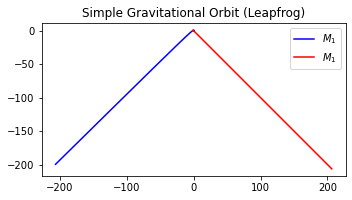

In [16]:
#Plot!!
fig=plt.figure(figsize=(5,5))

ax = fig.add_subplot(1,1,1)

start, stop = start_stop_indices(t_pts, t_start, t_end)    
ax.plot(x1,y1,color='blue',label=r'$M_1$')
ax.plot(x2,y2,color='red',label=r'$M_1$')

ax.set_title('Simple Gravitational Orbit (Leapfrog)')
ax.legend()
ax.set_aspect(1)

fig.tight_layout()
fig.savefig('simple_orbits.png', bbox_inches='tight')


## Adding more orbing objects

In [17]:
class Gravitational_orbit_3():
    """
     Gravitational_orbit class implements the parameters and Lagrange's equations for 
     two bodies orbiting under gravity.
     
    Parameters
    ----------
   
    G : float
        gravitational acceleration 
    Mn : float
        mass of pendulum, n is the pendulum bob number 

    Methods
    -------
    dy_dt(t, y)
        Returns the right side of the differential equation in vector y, 
        given time t and the corresponding value of y.
    """
    
    def __init__(self, M1 = 1., M2 = 1., M3 =1., G = 1.):
        
        self.M1 = M1
        self.M2 = M2
        self.M3 = M3
        self.G = G
        
    def dz_dt(self, t, z):
        """
        This function returns the right-hand side of the diffeq: 
        [dz/dt d^2z/dt^2]
        
        Parameters
        ----------
        y : float
            A 12-component vector with 
            z[0] = x1(t) and z[1] = dx1/dt
            z[2] = y1(t) and z[3] = dy1/dt
            z[4] = x2(t) and z[5] = dx2/dt
            z[6] = y2(t) and z[7] = dy2/dt
            z[8] = x3(t) and z[9] = dx3/dt
            z[10] = y3(t) and z[11] = dy3/dt
        t : float
            time 
            
        Returns
        -------
        
        """
        r_12 = np.sqrt((z[0]-z[4])**2 + (z[2]-z[6])**2 )
        r_23 = np.sqrt((z[4]-z[8])**2 + (z[6]-z[10])**2 )
        r_13 = np.sqrt((z[0]-z[8])**2 + (z[2]-z[10])**2 )
                  
        return [z[1], self.G*self.M2*(z[4]-z[0])/r_12**3 + self.G*self.M3*(z[8]-z[0])/r_13**3,\
               z[3], self.G*self.M2*(z[6]-z[2])/r_12**3 + self.G*self.M3*(z[10]-z[2])/r_13**3,\
               z[5], -self.G*self.M1*(z[4]-z[0])/r_12**3- self.G*self.M3*(z[8]-z[4])/r_23**3,\
               z[7], -self.G*self.M1*(z[6]-z[2])/r_12**3- self.G*self.M3*(z[10]-z[2])/r_23**3,\
               z[9], -self.G*self.M1*(z[8]-z[0])/r_13**3-self.G*self.M2*(z[8]-z[4])/r_13**3,\
               z[11], -self.G*self.M1*(z[10]-z[2])/r_13**3-self.G*self.M2*(z[10]-z[2])/r_13**3,\
               ]
    
   
    def solve_ode(self, t_pts, z_0,
                  abserr=1.0e-8, relerr=1.0e-8):
        """
        Solve the ODE given the array of time points and initial conditions.
        Specify smaller abserr and relerr to get more precision.
        """
       
        solution = solve_ivp(self.dz_dt, (t_pts[0], t_pts[-1]), z_0,
                             t_eval = t_pts, method='RK23',
                             atol=abserr, rtol=relerr)
        x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot, x3, x3_dot, y3, y3_dot  = solution.y
        
        return x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot,x3, x3_dot, y3, y3_dot

In [18]:
orbit_labels = (r'$x$', r'$y$')

# Plotting time 
t_start = 0.
t_end = 10.
delta_t = 0.01

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

G =1. 
M1= 1.
M2 =5.
M3 = 20.

o1=Gravitational_orbit_3(M1,M2,M3,G)

#initial conditions:
x1_0, x1_dot_0 = 1., -1.
y1_0, y1_dot_0 = 1., 1.
x2_0, x2_dot_0 = -(M1/M2)*x1_0 - (M1/M3)*x1_0, -(M1/M2)*x1_dot_0 -(M1/M3)*x1_dot_0
y2_0, y2_dot_0 = -(M1/M2)*y1_0-(M1/M3)*y1_0, -(M1/M2)*y1_dot_0-(M1/M3)*y1_dot_0
x3_0, x3_dot_0 = -(M2/M3)*x2_0-(M1/M2)*x2_0, -(M2/M3)*x2_dot_0-(M1/M2)*x2_dot_0
y3_0, y3_dot_0 = -(M2/M3)*y2_0-(M1/M2)*y2_0, -(M2/M3)*y2_dot_0-(M1/M2)*y2_dot_0

z_0 = [x1_0, x1_dot_0, y1_0, y1_dot_0, x2_0, x2_dot_0, y2_0, y2_dot_0, x3_0, x3_dot_0, y3_0, y3_dot_0]
x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot, x3, x3_dot, y3, y3_dot=o1.solve_ode(t_pts,z_0)


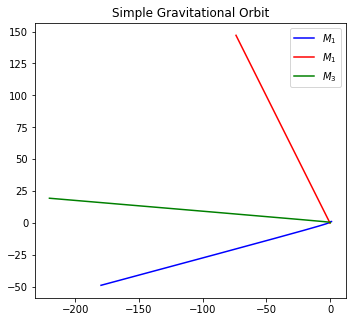

In [19]:
#Plot!!
fig=plt.figure(figsize=(5,5))

ax = fig.add_subplot(1,1,1)

start, stop = start_stop_indices(t_pts, t_start, t_end)    
ax.plot(x1,y1,color='blue',label=r'$M_1$')
ax.plot(x2,y2,color='red',label=r'$M_1$')
ax.plot(x3,y3,color='green',label=r'$M_3$')
ax.set_title('Simple Gravitational Orbit')
ax.legend()
ax.set_aspect(1)

fig.tight_layout()
fig.savefig('simple_orbits.png', bbox_inches='tight')
